<a href="https://colab.research.google.com/github/Alimv81/emotion_detection_FER2013/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up the gpu card for boosting performance speed and importing essential libraries

In [ ]:
import os
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11017014014193813248
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14357954560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2171046453972146159
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
import cv2
import zipfile
import numpy as np
import pandas as pd
from keras import regularizers
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers, losses, optimizers
from keras import callbacks
from sklearn.ensemble import RandomForestClassifier

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# preparing the dataset for the project

1. reading and downloading the dataset

In [ ]:
url = "https://huggingface.co/spaces/mxz/emtion/resolve/c697775e0adc35a9cec32bd4d3484b5f5a263748/fer2013.csv"
df = pd.read_csv(url)

2. checking the dataset sample of 5 rows

In [ ]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


3. checking the size of each training, validation and test datasets

In [ ]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

# Preprocessing the datasets

1. spliting the dataset into needed parts

In [ ]:
df_train = df[df['Usage']=='Training'].copy()
df_test = df[df['Usage']=='PublicTest'].copy()
df_valid = df[df['Usage']=='PrivateTest'].copy()

2. seperate the image pixles and labels for each data in three datasets

In [ ]:
num_classes = 7
input_shape = (48, 48, 3)

def split_data(data):
  data['pixels'] = data['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
  images = np.array(data['pixels'].tolist(), dtype='float32').reshape(-1, 48, 48, 1) / 255.0
  images = np.repeat(images, 3, axis=-1) # to make the channels of the image into 3
  labels = data['emotion'].to_numpy()

  return images, labels

In [ ]:
train_data, train_labels = split_data(df_train)
test_data, test_labels = split_data(df_test)
validation_data, validation_labels = split_data(df_valid)

# Defining image genrator for data augmentation(optional to use)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.25,
    fill_mode='nearest'
)

# Constructing and building the cnn model

1. implmenting models architecture

In [ ]:
model = Sequential()

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.SeparableConv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_classes, activation='softmax'))

2. compiling the model

In [ ]:
optimizer = optimizers.Adam()
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

3. taking a look on it's layers

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 256)       295168    
                                                                 
 batch_normalization (Batch  (None, 48, 48, 256)       1024      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                                 
 separable_conv2d (Separabl  (None, 24, 24, 128)       35200     
 eConv2D)                                                        
                                                        

4. defining callback options for the model to save the best one, choosing the learning rate and early stoping in case of descending or static performance(optional to use)

In [ ]:
early_stopping = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint("best_model.h5", save_best_only=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)

5. calling the models fit function to train the model on train dataset

In [ ]:
history = model.fit(
    datagen.flow(train_data, train_labels, batch_size=64),
    epochs=35,
    validation_data=(validation_data, validation_labels),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/35
449/449 [==============================] - ETA: 0s - loss: 1.8224 - accuracy: 0.2714

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


449/449 [==============================] - 67s 109ms/step - loss: 1.8224 - accuracy: 0.2714 - val_loss: 2.0712 - val_accuracy: 0.2444 - lr: 0.0010
Epoch 2/35
449/449 [==============================] - 51s 114ms/step - loss: 1.6292 - accuracy: 0.3568 - val_loss: 1.7265 - val_accuracy: 0.3160 - lr: 0.0010
Epoch 3/35
449/449 [==============================] - 46s 103ms/step - loss: 1.4662 - accuracy: 0.4342 - val_loss: 1.3275 - val_accuracy: 0.4901 - lr: 0.0010
Epoch 4/35
449/449 [==============================] - 47s 104ms/step - loss: 1.3458 - accuracy: 0.4856 - val_loss: 1.3236 - val_accuracy: 0.4985 - lr: 0.0010
Epoch 5/35
449/449 [==============================] - 46s 103ms/step - loss: 1.2677 - accuracy: 0.5148 - val_loss: 1.4559 - val_accuracy: 0.4712 - lr: 0.0010
Epoch 6/35
449/449 [==============================] - 46s 103ms/step - loss: 1.2050 - accuracy: 0.5387 - val_loss: 1.1058 - val_accuracy: 0.5798 - lr: 0.0010
Epoch 7/35
449/449 [==============================] - 48s 107ms

# Monitoring the models performance

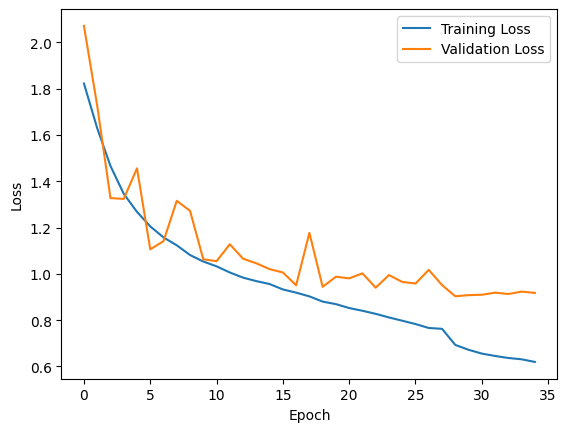

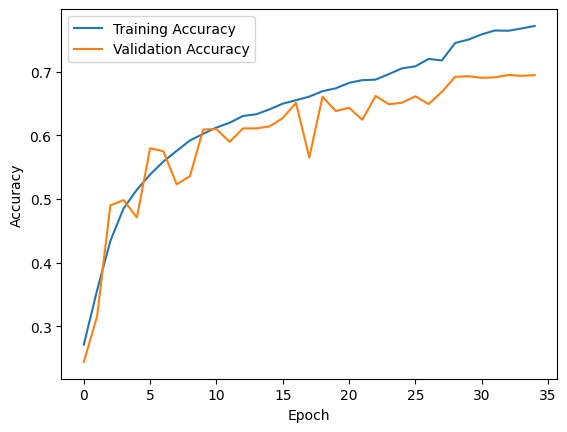

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Checking the models predicted values to the true labels of each image available in test dataset

1. defining the emotion_map to decode the meaning of each prediction done by the model

In [ ]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

2. predicting the emotions in each image

In [ ]:
predy = model.predict(test_data)

113/113 [==============================] - 1s 10ms/step


In [ ]:
predy[0], np.argmax(predy[0])

(array([8.0974811e-01, 3.0429759e-05, 3.7853664e-03, 4.0782421e-04,
        1.8571520e-01, 5.6686782e-05, 2.5649770e-04], dtype=float32),
 0)

3. using accuracy_score metrics to determine the model

In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(test_labels, np.argmax(predy, axis=1)))

0.6720534967957649


4. loading 4 random images from test dataset and using the model to predict the emotions in them

In [ ]:
idx = [81, 669, 1288, 2743]
image_batch = test_data[idx]
label_batch = test_labels[idx]
label_batch_pred = np.argmax(predy[idx], axis=1)

5. plotting the images and the true emotions in them vs the predicted emotions

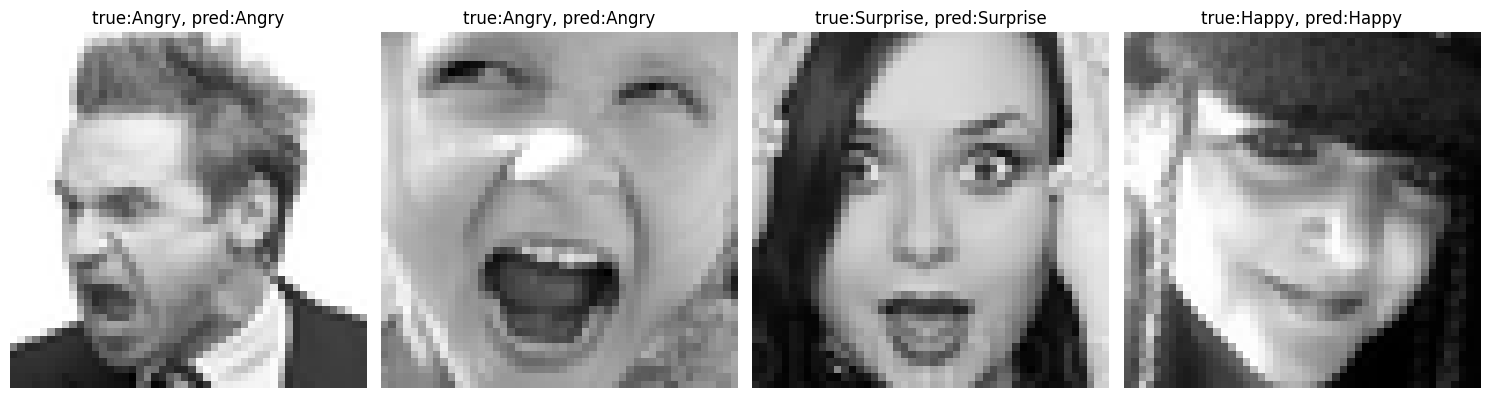

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i, ax in enumerate(axes):
    image = image_batch[i]
    ax.imshow(image)
    ax.set_title(f'true:{emotion_map[label_batch[i]]}, pred:{emotion_map[label_batch_pred[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Using a svc model and stacking it over predicted values by the main model and see the results of the accuracy score

In [ ]:
rfc_model = RandomForestClassifier()

y_hat_train = model.predict(train_data)
rfc_model.fit(y_hat_train, train_labels)

898/898 [==============================] - 9s 10ms/step


RandomForestClassifier()

In [ ]:
y_hat_test = model.predict(test_data)
y_hat_test_rfc = rfc_model.predict(y_hat_test)

113/113 [==============================] - 1s 10ms/step


In [ ]:
print(accuracy_score(test_labels, y_hat_test_rfc))

0.673725271663416


# Doing the same testing method on 11 personal images and checking the predicted emotions for the unlabeled images

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Datasets/File.zip'

In [ ]:
with zipfile.ZipFile(path, 'r') as zip_ref:
  zip_ref.extractall('extracted/')

In [ ]:
images = []

files_names = os.listdir('extracted/')
for file_name in files_names:
  # image = cv2.imread(os.path.join('extracted', file_name), cv2.IMREAD_GRAYSCALE) # use this line if you want image channels number to be 1
  image = cv2.imread(os.path.join('extracted', file_name), cv2.IMREAD_COLOR) # use this line if you want image channels number to be 3

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (48, 48))
  image = image.astype('float32') / 255.0
  # image = np.expand_dims(image, axis=-1) # use this line for one channeled images
  images.append(image)

In [ ]:
images = np.array(images)
y_hat = np.argmax(model.predict(images), axis=1)

1/1 [==============================] - 0s 463ms/step


In [ ]:
images.shape

(11, 48, 48, 3)

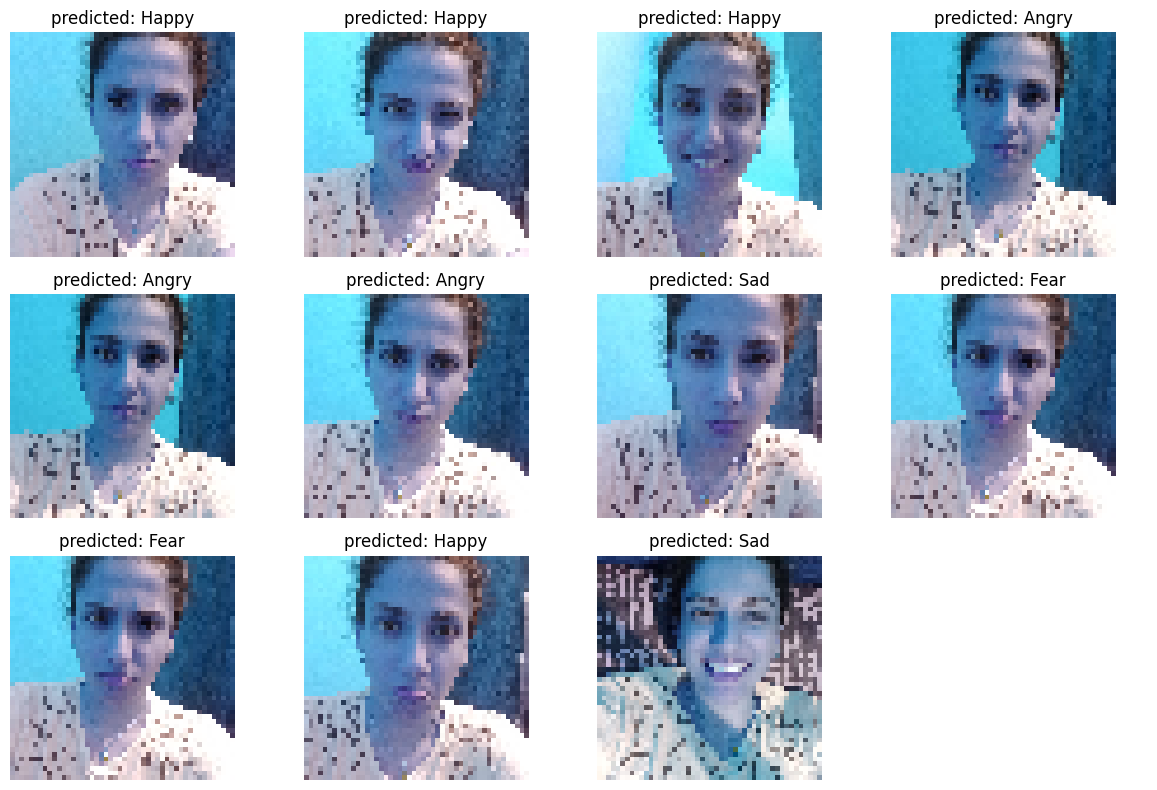

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))

for i in range(3):
  for j in range(4):
    ax = axes[i][j]
    if i!=2 or j!=3:
      ax.imshow(images[i*3 + j])
      ax.set_title(f'predicted: {emotion_map[y_hat[i*3 + j]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()